### Cifar - 10 이미지 분류 v2
- 데이터 부풀리기 적용

In [21]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(2022)
tf.random.set_seed(2022)

- 데이터 전처리

In [22]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

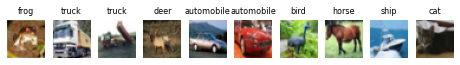

In [24]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


plt.figure(figsize=(8,2))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(X_train[i]), plt.axis('off')
  plt.title(class_names[y_train[i,0]], fontsize=8)
plt.show()

In [25]:
# X data : 0~1 사이의 실수(float32)로 변환, float 변환을 안 할시 64비트로 처리
X_train = X_train.astype('float32')/255.
X_test = X_test.astype(np.float32)/255.

In [26]:
# y data : one-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

- 모델 정의/설정/학습/평가

In [27]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [28]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'),  #padding=32
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)        18464     
                                                      

In [29]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
model_path = 'best-cifar10-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 데이터 부풀리기

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
  featurewise_center=False,            # set input mean to 0 over the dataset
  samplewise_center=False,             # set each sample mean to 0
  featurewise_std_normalization=False, # divide inputs by std of dataset
  samplewise_std_normalization=False,  # divide each input by its std
  zca_whitening=False,                 # apply ZCA whitening
  zca_epsilon=1e-06,                   # epsilon for ZCA whitening
  rotation_range=0,                    # randomly rotate images in the range (deg 0 to 180)
  width_shift_range=0.1,               # randomly shift images horizontally
  height_shift_range=0.1,              # randomly shift images vertically
  shear_range=0.,                      # set range for random shear
  zoom_range=0.1,                      # set range for random zoom
  channel_shift_range=0.,              # set range for random channel shifts
  fill_mode='nearest',                 # set mode for filling points outside the input boundaries
  cval=0.,                             # value used for fill_mode = "constant"
  horizontal_flip=True,                # randomly flip images
  vertical_flip=False,                 # randomly flip images
  rescale=None,                        # set rescaling factor (applied before any other transformation)
  preprocessing_function=None,         # set function that will be applied on each input
  data_format=None,                    # image data format, either "channels_first" or "channels_last"
  validation_split=0.0                 # fraction of images reserved for validation
)
datagen.fit(X_train)

In [33]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid),
    epochs=100, verbose=2, callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.70237, saving model to best-cifar10-v2.h5
1250/1250 - 22s - loss: 1.9224 - accuracy: 0.2885 - val_loss: 1.7024 - val_accuracy: 0.3876 - 22s/epoch - 18ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 1.70237 to 1.49317, saving model to best-cifar10-v2.h5
1250/1250 - 20s - loss: 1.6580 - accuracy: 0.3898 - val_loss: 1.4932 - val_accuracy: 0.4602 - 20s/epoch - 16ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 1.49317 to 1.44853, saving model to best-cifar10-v2.h5
1250/1250 - 21s - loss: 1.5576 - accuracy: 0.4293 - val_loss: 1.4485 - val_accuracy: 0.4873 - 21s/epoch - 17ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 1.44853 to 1.38782, saving model to best-cifar10-v2.h5
1250/1250 - 20s - loss: 1.4889 - accuracy: 0.4560 - val_loss: 1.3878 - val_accuracy: 0.5003 - 20s/epoch - 16ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 1.38782 to 1.36478, saving model to best-cifar10-v2.h5
1250/1250 - 21s - lo

In [34]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8202 - accuracy: 0.7167


[0.8202250003814697, 0.71670001745224]

- 학습과정 시각화

In [38]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

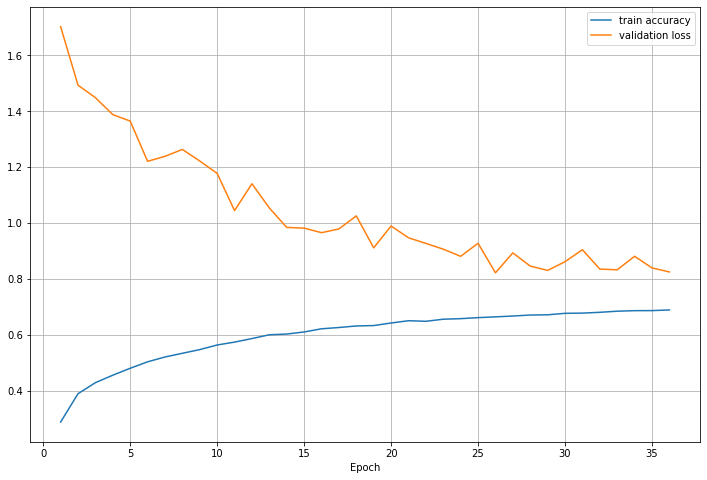

In [39]:
plt.figure(figsize=(12,8))
plt.plot(xs,y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()